## Feature Extraction: Under the hood

In [66]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa.display

## Orginial Signal

In [2]:
sample_rate, signal = scipy.io.wavfile.read('../../../Source/Clean_train_clips/Shuffle/1/1.wav')  


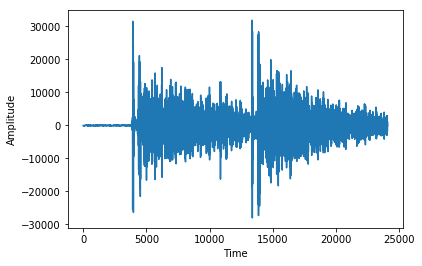

In [3]:
plt.plot(signal)
plt.xlabel('Time')
plt.ylabel('Amplitude');

## Pre-emphasis filter

In [4]:
pre_emphasis = 0.97 # Typically 0.95 or 0.97 for Automatic Speech Recognition (ASR)

In [5]:
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

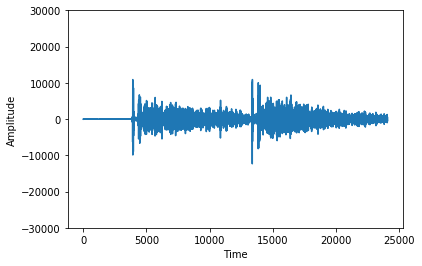

In [6]:
plt.plot(emphasized_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.ylim(-30000, 30000);

## Framing

In [7]:
frame_size = 0.025 # 25 msec (Typically 20-40 msec for ASR)
frame_stride = 0.010 # 10 msec with 15 msec overlap (Typically 50% overlap)


In [8]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [9]:
frames.shape

(53, 1102)

## Apply (Hamming) window function to each frame

In [10]:
frames *= np.hamming(frame_length)

In [11]:
#frames

## Fourier Transform and Power Spectrum

In [12]:
NFFT = 512 # Typically 256 or 512

In [13]:
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [14]:
mag_frames.shape

(53, 257)

In [15]:
pow_frames.shape

(53, 257)

## Filter Banks

In [16]:
nfilt = 40

In [17]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate) # floor rounds to the nearest int

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [18]:
filter_banks.shape

(53, 40)

In [19]:
np.mean(filter_banks.T, axis=1)

array([ 67.20410593,  71.78584062,  74.69071379,  78.30720305,
        81.38085351,  81.80640344,  81.00076178,  87.08329411,
        88.62823962,  92.61256762,  98.11474573,  99.47794297,
       102.6462723 , 109.40130496, 119.86804961, 132.02084726,
       134.02159705, 129.58021966, 125.55929515, 130.19082786,
       125.45892847, 117.23981929, 112.66497624, 105.83014309,
       107.05413746, 103.70648944, 100.87180245,  99.26074309,
        96.49045316,  87.32350816,  82.3809065 ,  84.77444466,
        84.08868742,  83.07556553,  83.90320604,  81.78173102,
        81.41754437,  83.7337404 ,  87.53700513,  84.38410041])

## Mel-frequency Cepstral Coefficients (MFCCs)

In [20]:
num_ceps = 12

In [21]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [22]:
mfcc.shape

(53, 12)

## Mean Normalization

In [23]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

In [24]:
# filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [25]:
mfcc.shape

(53, 12)

## Feature Extraction with audio data using Mel-scaled Filterbanks

In [39]:
path_1 = '../../../Source/Clean_train_clips/Shuffle/1/1.wav'
path_2 = '../../../Source/Clean_train_clips/Ball_change/1/3.wav'
pre_emphasis = 0.97 # Typically 0.95 or 0.97 for Automatic Speech Recognition (ASR)
frame_size = 0.025 # 25 msec (Typically 20-40 msec for ASR)
frame_stride = 0.010 # 10 msec with 15 msec overlap (Typically 50% overlap)
NFFT = 512 # Typically 256 or 512
nfilt = 40

In [40]:
def get_filterbanks(path):
    sample_rate, signal = scipy.io.wavfile.read(path)  
    
    # Pre-emphasis filter
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Framing
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
    
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # Apply Hamming window function to each frame
    frames *= np.hamming(frame_length)
    
    # Fourier Transform and Power Spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    
    # Mel-scaled Filterbanks
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate) # floor rounds to the nearest int
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
    
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    # Mean Normalization
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    return filter_banks
    
    #return np.mean(filter_banks.T, axis=1)

In [42]:
(get_filterbanks(path_1)).shape

(53, 40)

In [43]:
(get_filterbanks(path_2)).shape

(56, 40)

Hmm...OK, it seems like all clips must be the same length to get features of a similar shape with the mel-filterbank approach. <br/> What length (duration) do all my clips have?

In [96]:
duration_list = []
for i in range(len(tap)):
    signal, sample_rate = librosa.load(tap.loc[i, 'Path'])
    duration_list.append(librosa.get_duration(y= signal, sr = sample_rate))
print ('Longest: ' + str(max(duration_list)))
print ('Shortest: ' + str(min(duration_list)))

Longest: 0.7780045351473923
Shortest: 0.20099773242630387


There appears to be quite a range of lengths, from 0.20 seconds to 0.78 seconds. <br/> How can I edit these without losing any information? <br/> 

In [99]:
mid_duration_list = []
for length in duration_list:
    if length >= 0.50: 
        if length <= 0.55:
            mid_duration_list.append(length)
        

In [102]:
len(mid_duration_list), len(duration_list)

(53, 312)

I don't know.

## Let's do this thing: New features for all audio clips

In [44]:
def build_list(step, folder, length):
    i = 1
    step_list = []
    while i <= length :
        name = step + "/" + str(folder) + "/" +str(i) + ".wav"
        step_list.append(name)
        i += 1
    return step_list

def get_label(path):
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0

In [45]:
shuffle_col, bc_col, path_col = [], [], []

In [46]:
pathlist = Path('../../../Source/Clean_train_clips/Shuffle').glob('**/*.wav')
for path in pathlist:
    shuffle_col.append(path)
    shuffle_col.sort()

In [47]:
pathlist = Path('../../../Source/Clean_train_clips/Ball_change').glob('**/*.wav')
for path in pathlist:
    bc_col.append(path)
    bc_col.sort()

In [48]:
path_col = shuffle_col + bc_col

**Add file paths**

In [49]:
tap = pd.DataFrame({'Path':path_col})


**Add labels**

In [50]:
tap['Labels'] = [get_label(tap.loc[idx,'Path']) for idx in range(len(tap))]

**Add Features: Mel-scaled filterbanks**

In [51]:
#for i in range (nfilt):
#    tap[str(i)] = [get_filterbanks(tap.loc[idx, 'Path'])[i] for idx in range (len(tap))]

**Export data as csv**

In [ ]:
#tap.to_csv('../../../Source/Data/audio_data_filterbanks.csv', index=None)

**Split into train and test sets**

In [ ]:
X = tap.drop(['Labels'], axis =1)
y = tap[['Labels']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
#X_train.to_csv('../../../Source/Data/X_train_audio_filterbanks.csv', index=None)
#y_train.to_csv('../../../Source/Data/y_train_audio_filterbanks.csv', index=None)
#X_test.to_csv('../../../Source/Data/X_test_audio_filterbanks.csv', index=None)
#y_test.to_csv('../../../Source/Data/y_test_audio_filterbanks.csv', index=None)

